In [1]:
import numpy as np
import gpytorch
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

def sample_functions(mean_func, k, num_samples=10, num_test=100, nugget=1e-3):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    # k = kernel_func(X)
    C = k.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1) 
        f = m[:, None] + L @ z  
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5, 
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )
    
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )

    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([num_samples])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)
    
    return dict(m_star=m_star, v_star=v_star, ax=ax)


def train(model, train_x, train_y, n_iter=10, lr=0.1, silent=True):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        if not silent:
            print(loss)
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0 and not silent:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


In [2]:

data = np.loadtxt('mauna_loa_co2.txt')
t = data[:, 2]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
t_s = t - t.min()
y_s = (y - y.min()) / (y.max() - y.min())
train_x = torch.from_numpy(t_s).float()
train_y = torch.from_numpy(y_s).float()
x_star = torch.linspace(0, 100, 100)

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-2.9727])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(1.0000e-04)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('mean_module.weights', tensor([[-1.0829]])), ('mean_module.bias', tensor([1.2743])), ('covar_module.kernels.0.raw_outputscale', tensor(0.5413)), ('covar_module.kernels.0.base_kernel.raw_lengthscale', tensor([[40.]])), ('covar_module.kernels.0.base_kernel.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.kernels.0.base_kernel.raw_lengthscale_constraint.upper_bound', tensor(inf)), ('covar_module.kernels.0.raw_outputscale_constraint.lower_bound', tensor(0.)), ('covar_module.kernels.0.raw_outputscale_constraint.upper_bound', tensor(inf)), ('covar_module.kernels.1.kernels.0.raw_outputscale', tensor(1.8546)), ('covar_module.kernels.1.kernels.0.base_kernel.raw_lengthscale', tensor([[-0.1959]])), ('covar_module.kernels.1.kernels.0.base_kernel.raw_period

/nix/store/bqd26h2mlj4zs4m58mdz1vi6gj4k89jn-python3-3.10.12-env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/nix/store/bqd26h2mlj4zs4m58mdz1vi6gj4k89jn-python3-3.10.12-env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


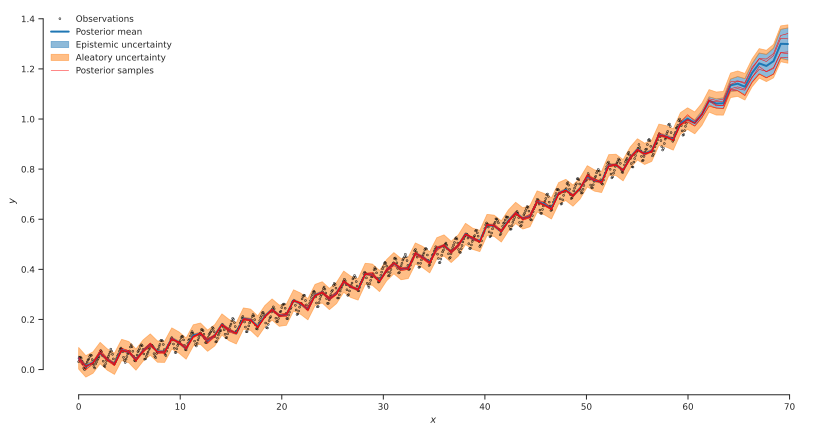

In [3]:
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, RQKernel

k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
k1.outputscale = 1
k1.base_kernel.lengthscale = 40

k21 = PeriodicKernel(period_length_prior=gpytorch.priors.NormalPrior(1, 0.5))
k21.lengthscale = 0.6

k22 = RBFKernel()
k22.lengthscale = 0.3

k2 = ScaleKernel(k21)# * k22)
k2.outputscale = 2

k3 = ScaleKernel(RQKernel())
k3.outputscale = 0.4
k3.base_kernel.alpha = 0.15
k3.base_kernel.lengthscale = 1

cov_module = k1 + k2 * k3

mean_module = gpytorch.means.LinearMean(1)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

likelihood.noise = 0.05

model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module,
    likelihood=likelihood
)

param_names = []
pre_params = []
post_params = []

for name, v in model.named_parameters():
    param_names.append(name)
    pre_params.append(v.item())

with gpytorch.settings.cholesky_jitter(1e-6):
    #     train(model, train_x, train_y)

    print(model.state_dict())

    train(model, train_x, train_y)

    print(model.state_dict())

    for name, v in model.named_parameters():
        post_params.append(v.item())

    for name, pre, post in zip(param_names, pre_params, post_params):
        print(f"{name}: {pre}, {post}")

    fig, ax = plt.subplots(figsize=(14, 7))
    plot_1d_regression(model=model, x_star=torch.linspace(0, t_s.max()+10, 100), ax=ax, num_samples=5);